# Import Libraries

In [147]:
!pip install -U keras-tuner

In [148]:
!pip install distance

In [149]:
!pip install fuzzywuzzy

In [150]:
pip install gensim

In [151]:
pip install numpy==1.23.5 gensim==4.3.2


In [152]:
pip install scipy==1.10.1

In [153]:
pip install --upgrade scikit-learn

In [154]:
pip install numpy==1.23.5 tensorflow==2.12.0

In [155]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import distance
import nltk
nltk.download('stopwords',quiet=True)
from nltk.corpus import stopwords
from fuzzywuzzy import fuzz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, ConfusionMatrixDisplay,roc_curve,auc,f1_score
from gensim.models import Word2Vec
from sklearn.svm import SVC
import pickle
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,SimpleRNN,LSTM
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import keras_tuner as kt


# Importing DataSet

In [156]:
df=pd.read_csv("train.csv")

In [157]:
df=df.sample(50000,random_state=2)

In [158]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
398782,398782,496695,532029,What is the best marketing automation tool for...,What is the best marketing automation tool for...,1
115086,115086,187729,187730,I am poor but I want to invest. What should I do?,I am quite poor and I want to be very rich. Wh...,0
327711,327711,454161,454162,I am from India and live abroad. I met a guy f...,T.I.E.T to Thapar University to Thapar Univers...,0
367788,367788,498109,491396,Why do so many people in the U.S. hate the sou...,My boyfriend doesnt feel guilty when he hurts ...,0
151235,151235,237843,50930,Consequences of Bhopal gas tragedy?,What was the reason behind the Bhopal gas trag...,0


In [159]:
df.shape

(50000, 6)

In [160]:
df['is_duplicate'].value_counts()

,count
is_duplicate,
0,31601
1,18399


In [161]:
df.head(1)

,id,qid1,qid2,question1,question2,is_duplicate
398782,398782,496695,532029,What is the best marketing automation tool for...,What is the best marketing automation tool for...,1


In [162]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 398782 to 226665
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            50000 non-null  int64 
 1   qid1          50000 non-null  int64 
 2   qid2          50000 non-null  int64 
 3   question1     50000 non-null  object
 4   question2     50000 non-null  object
 5   is_duplicate  50000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 2.7+ MB


In [163]:
df.sample(10)

,id,qid1,qid2,question1,question2,is_duplicate
245283,245283,82330,12131,What is the purpose of your life?,What should the purpose of your life?,1
379546,379546,511078,380426,How does a digital clock in cars or in any veh...,Is it bad for my car when I accidentally turn ...,0
229092,229092,338315,5488,Is cat worth a 1 year drop?,Should I drop 1 year after a BE for CAT prepar...,1
136891,136891,218301,83106,I have a computer science exam (12th board) on...,What should be my strategy to score more than ...,0
100296,100296,166391,166392,How do you improve footwork?,How can I improve footwork in cricket?,0
239575,239575,71948,24523,Will banning 500 and 1000 notes can stop the b...,How will banning the present 500/1000 notes fi...,1
155194,155194,243174,243175,How do you know a piece of information is stor...,Are there any ways to transfer information rec...,0
324588,324588,147846,176139,How do I make a rocket?,How do you make a DIY rocket that works?,1
232557,232557,342601,342602,How did Larry Page and Sergey Brin decide to h...,Do Sergey Brin and Larry Page really approve e...,0
89600,89600,150512,150513,How much can a fresh electrical engineering gr...,Why do we not see a persistent higher-than-ave...,0


In [164]:
df.isnull().sum()

,0
id,0
qid1,0
qid2,0
question1,0
question2,0
is_duplicate,0


In [165]:
df.duplicated().sum()

0

# Data Preprocessing

In [166]:
def preprocess_question(question):
    # Convert to lowercase and strip whitespace
    question = question.lower().strip()

    # Replace special characters with their string equivalents
    replacements = {
        '%': ' percent ', '$': ' dollar ', '₹': ' rupee ', '€': ' euro ', '@': ' at ', '[math]': ''
    }
    for key, val in replacements.items():
        question = question.replace(key, val)

    # Replace large numbers with their word equivalents
    large_number_replacements = {
        r'(\d+)000000000000': r'\1 trillion',
        r'(\d+)000000000': r'\1 billion',
        r'(\d+)000000': r'\1 million',
        r'(\d+)000': r'\1 thousand'
    }
    for key, val in large_number_replacements.items():
        question = re.sub(key, val, question)

    # Expand contractions
    contractions = {
        "ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have",
        "could've": "could have", "couldn't": "could not", "didn't": "did not", "doesn't": "does not",
        "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
        "he'd": "he would", "he'd've": "he would have", "he'll": "he will", "he'll've": "he will have",
        "he's": "he is", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",
        "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not",
        "it's": "it is", "it'd": "it would", "it'd've": "it would have", "let's": "let us",
        "ma'am": "madam", "mustn't": "must not", "needn't": "need not", "o'clock": "of the clock",
        "oughtn't": "ought not", "shan't": "shall not", "sha'n't": "shall not", "should've": "should have",
        "shouldn't": "should not", "shouldn't've": "should not have", "that'd": "that would",
        "that'd've": "that would have", "that's": "that is", "there'd": "there would",
        "there'd've": "there would have", "there's": "there is", "they'd": "they would",
        "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have",
        "they're": "they are", "they've": "they have", "wasn't": "was not", "we'd": "we would",
        "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
        "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have",
        "what're": "what are", "what's": "what is", "what've": "what have", "where'd": "where did",
        "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have",
        "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have",
        "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have",
        "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
        "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are",
        "y'all've": "you all have", "you'd": "you would", "you'd've": "you would have",
        "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have",
        "'cause": "because", "'til": "until", "'tis": "it is", "'twas": "it was", "'d": " would",
        "'ll": " will", "'re": " are", "'ve": " have", "n't": " not"
    }
    question = ' '.join([contractions[word] if word in contractions else word for word in question.split()])

    # Remove HTML tags
    question = BeautifulSoup(question, "html.parser").get_text()

    # Remove punctuation and extra spaces
    question = re.sub(r'\W+', ' ', question).strip()

    return question

In [167]:
question = "What's the capital of France? Isn't it Paris?"
preprocessed_question = preprocess_question(question)
print(preprocessed_question)

what is the capital of france is not it paris


# Question Embedding

In [168]:
sentences = [q.split() for q in df["question1"]] + [q.split() for q in df["question2"]]

Word2vec

In [169]:
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

In [170]:
def get_avg_word2vec(question, model):
    vectors = [model.wv[word] for word in question.split() if word in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

In [171]:
df["q1_word2vec"] = df["question1"].apply(lambda x: get_avg_word2vec(x, word2vec_model))
df["q2_word2vec"] = df["question2"].apply(lambda x: get_avg_word2vec(x, word2vec_model))

# Feature Engineering

In [172]:
STOP_WORDS = set(stopwords.words('english'))
# Function to compute additional features
def compute_additional_features(row):
    question1 = row["question1"]
    question2 = row["question2"]

    # Word count features
    q1_len = len(question1.split())
    q2_len = len(question2.split())
    abs_len_diff = abs(q1_len - q2_len)

    # Common words
    q1_words = set(question1.split())
    q2_words = set(question2.split())
    common_words = len(q1_words.intersection(q2_words))

    # Fuzzy matching scores
    fuzz_ratio = fuzz.ratio(question1, question2)
    fuzz_partial_ratio = fuzz.partial_ratio(question1, question2)
    token_sort_ratio = fuzz.token_sort_ratio(question1, question2)
    token_set_ratio = fuzz.token_set_ratio(question1, question2)

    # Token features
    q1_tokens = question1.split()
    q2_tokens = question2.split()
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    common_word_count = len(q1_words.intersection(q2_words))
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))

    cwc_min = common_word_count / (min(len(q1_words), len(q2_words)) + 0.0001)
    cwc_max = common_word_count / (max(len(q1_words), len(q2_words)) + 0.0001)
    ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + 0.0001)
    ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + 0.0001)

    # Check if questions have tokens before accessing first/last token
    last_word_eq = int(q1_tokens[-1] == q2_tokens[-1]) if q1_tokens and q2_tokens else 0
    first_word_eq = int(q1_tokens[0] == q2_tokens[0]) if q1_tokens and q2_tokens else 0

    # Length-based features
    longest_substr = list(distance.lcsubstrings(question1, question2))
    longest_substr_length = len(longest_substr[0]) if longest_substr else 0
    mean_len = (len(q1_tokens) + len(q2_tokens)) / 2
    longest_substr_ratio = longest_substr_length / (min(len(question1), len(question2)) + 1)

    # Skimming feature
    skimming_feature = len(set(q1_tokens).intersection(set(q2_tokens))) / (min(len(q1_tokens), len(q2_tokens)) + 1)

    # Word share
    total_words = len(q1_words) + len(q2_words)
    word_share = common_words / total_words if total_words > 0 else 0

    # Total words
    total_words_feature = total_words

    # Additional features
    q1_new_word = len(question1.split())
    q2_new_word = len(question2.split())

    # Combine all features into a single array
    features = np.array([
        q1_len, q2_len, abs_len_diff, common_words, fuzz_ratio, fuzz_partial_ratio,
        token_sort_ratio, token_set_ratio, cwc_min, cwc_max, ctc_min, ctc_max,
        last_word_eq, first_word_eq, mean_len, longest_substr_ratio, skimming_feature,
        word_share, total_words_feature, q1_new_word, q2_new_word
    ])
    return features

In [173]:
df["additional_features"] = df.apply(compute_additional_features, axis=1)

In [174]:
def combine_features(row):
    return np.hstack((row["q1_word2vec"], row["q2_word2vec"], row["additional_features"]))

In [175]:
df["combined_features"] = df.apply(combine_features, axis=1)

# Exploratory Data Analysis(EDA)

In [176]:
df['question1']=df['question1'].apply(preprocess_question)
df['question2']=df['question2'].apply(preprocess_question)

is_duplicate
0    31601
1    18399
Name: count, dtype: int64
is_duplicate
0    63.202
1    36.798
Name: count, dtype: float64


<Axes: xlabel='is_duplicate'>

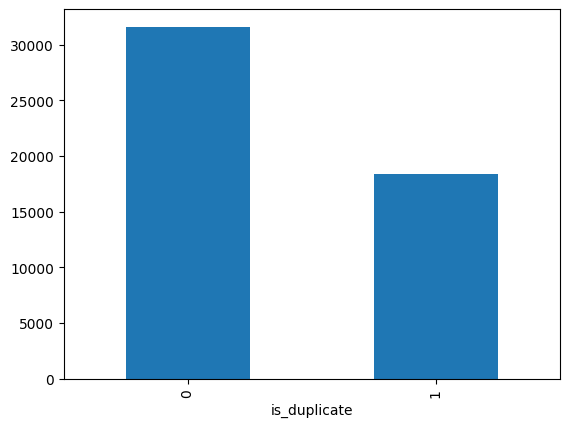

In [177]:
print(df['is_duplicate'].value_counts())
print((df['is_duplicate'].value_counts()/df['is_duplicate'].count())*100)
df['is_duplicate'].value_counts().plot(kind='bar')

In [178]:
qid=pd.Series(df['qid1'].tolist()+df['qid2'].tolist())
print("Number of unique question",np.unique(qid).shape[0])
x=qid.value_counts()>1
print("Number of duplicate question",x[x].shape[0])

Number of unique question 88945
Number of duplicate question 7384


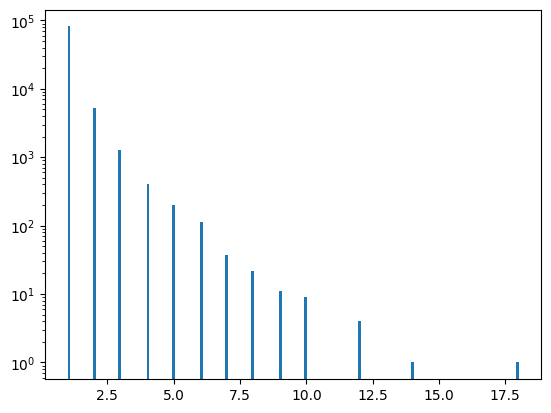

In [179]:
plt.hist(qid.value_counts().values,bins=160)
plt.yscale('log')
plt.show()

# DataSet Split

In [180]:
X = np.array(df["combined_features"].tolist())
y = df["is_duplicate"].values

In [181]:
X

array([[-0.04766988,  0.57118052, -0.2521899 , ..., 16.        ,
        12.        , 12.        ],
       [-0.64272839,  1.65761316, -1.86623228, ..., 13.        ,
        12.        , 15.        ],
       [-0.12269092,  1.1590662 , -1.32163799, ..., 23.        ,
        25.        , 17.        ],
       ...,
       [ 0.28754348, -0.21988995, -1.12627494, ...,  8.        ,
         5.        ,  5.        ],
       [-0.03100375,  0.53560764, -0.17799193, ..., 14.        ,
        12.        , 10.        ],
       [ 0.16825357,  0.44620895, -0.4613412 , ..., 11.        ,
         8.        , 10.        ]])

In [182]:
y

array([1, 0, 0, ..., 0, 0, 0])

# Train Test Split

In [183]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.4,random_state=42)

In [184]:
print(X_train.shape)

(30000, 221)


In [185]:
X_train

array([[ 2.31997699e-01,  1.64007127e-01, -5.27921133e-02, ...,
         1.70000000e+01,  9.00000000e+00,  1.50000000e+01],
       [-3.10852617e-01,  1.06415224e+00, -1.25872076e+00, ...,
         1.30000000e+01,  7.00000000e+00,  1.10000000e+01],
       [ 2.57424917e-02,  2.42596403e-01,  3.16703558e-01, ...,
         1.00000000e+01,  8.00000000e+00,  8.00000000e+00],
       ...,
       [-7.58991003e-01,  1.29029799e+00, -8.22738230e-01, ...,
         1.00000000e+01,  6.00000000e+00,  7.00000000e+00],
       [-7.01007307e-01,  1.22176611e+00, -9.98308003e-01, ...,
         9.00000000e+00,  7.00000000e+00,  5.00000000e+00],
       [ 2.53382593e-01,  7.88468599e-01, -9.41893280e-01, ...,
         2.40000000e+01,  1.70000000e+01,  3.00000000e+01]])

In [186]:
y_train

array([0, 1, 0, ..., 1, 1, 1])

In [187]:
X_test

array([[ 0.67996931,  1.2025317 , -1.73553479, ..., 10.        ,
        12.        ,  9.        ],
       [-0.35105237,  1.50477695, -0.72302097, ..., 16.        ,
        12.        , 10.        ],
       [-0.42039344,  0.3025052 ,  0.20816174, ..., 12.        ,
        11.        ,  7.        ],
       ...,
       [ 0.14177957,  0.34741992,  0.15569961, ..., 10.        ,
        10.        ,  8.        ],
       [-0.40479445,  1.24374461, -1.23579836, ..., 10.        ,
         9.        ,  9.        ],
       [ 0.0823687 ,  1.01722777, -1.15706325, ..., 17.        ,
        18.        , 11.        ]])

In [188]:
y_test

array([1, 0, 0, ..., 1, 0, 0])

# Random Forest Classifier

In [189]:
rfc=RandomForestClassifier()
rfc.fit(X_train,y_train)

RandomForestClassifier()

In [190]:
y_pred_rfc=rfc.predict(X_test)

In [191]:
accuracy_score(y_test,y_pred_rfc)

0.7887

In [192]:
f1_model = f1_score(y_test, y_pred_rfc, average='macro')
print(f"F1 Score: {f1_model:.4f}")

F1 Score: 0.7723


In [193]:
cm=confusion_matrix(y_test,y_pred_rfc)

Visualization

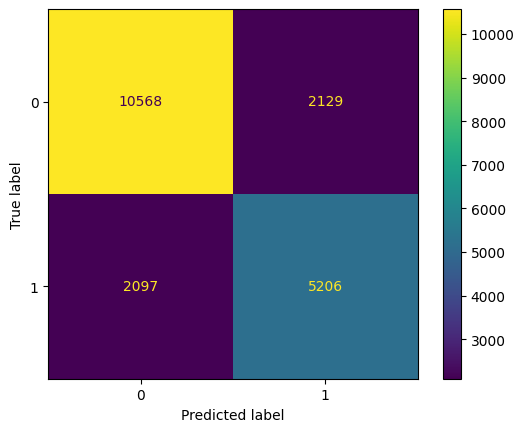

In [194]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc.classes_)
disp.plot()

# XGB Classifier

In [195]:
xgb = XGBClassifier()

In [196]:
xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [197]:
y_pred_xgb = xgb.predict(X_test)

In [198]:
accuracy_score(y_test,y_pred_xgb)

0.79135

In [199]:
f1_model = f1_score(y_test, y_pred_xgb, average='macro')
print(f"F1 Score: {f1_model:.4f}")

F1 Score: 0.7756


In [200]:
cm=confusion_matrix(y_test,y_pred_xgb)

Visualization

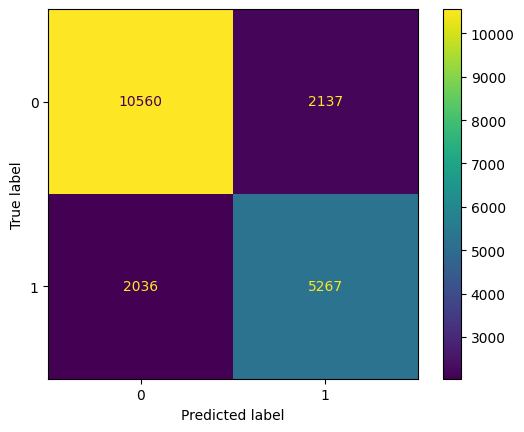

In [201]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb.classes_)
disp.plot()

# SVM

In [202]:
svm=SVC()

In [203]:
svm.fit(X_train,y_train)

SVC()

In [204]:
y_pred_svm=svm.predict(X_test)

In [205]:
accuracy_score(y_test,y_pred_svm)

0.73815

In [206]:
f1_model=f1_score(y_test,y_pred_svm,average='macro')
print(f"F1 Score: {f1_model:.4f}")

F1 Score: 0.7172


In [207]:
cm=confusion_matrix(y_test,y_pred_svm)

Visualization

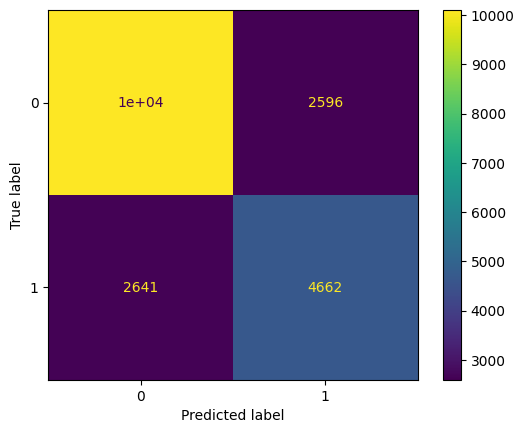

In [208]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm.classes_)
disp.plot()

# RNN

In [209]:
X = X.reshape(X.shape[0], 1, X.shape[1])

In [210]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [211]:
model = Sequential([
    SimpleRNN(128, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    SimpleRNN(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [212]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [213]:
history_rnn=model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
938/938 [==============================] - 10s 8ms/step - loss: 0.6072 - accuracy: 0.6487 - val_loss: 0.5235 - val_accuracy: 0.6795
Epoch 2/10
938/938 [==============================] - 6s 7ms/step - loss: 0.5270 - accuracy: 0.6920 - val_loss: 0.4931 - val_accuracy: 0.7311
Epoch 3/10
938/938 [==============================] - 7s 8ms/step - loss: 0.5058 - accuracy: 0.7151 - val_loss: 0.4918 - val_accuracy: 0.7305
Epoch 4/10
938/938 [==============================] - 6s 6ms/step - loss: 0.4943 - accuracy: 0.7267 - val_loss: 0.4832 - val_accuracy: 0.7337
Epoch 5/10
938/938 [==============================] - 8s 8ms/step - loss: 0.4870 - accuracy: 0.7337 - val_loss: 0.4701 - val_accuracy: 0.7534
Epoch 6/10
938/938 [==============================] - 6s 6ms/step - loss: 0.4817 - accuracy: 0.7359 - val_loss: 0.4714 - val_accuracy: 0.7560
Epoch 7/10
938/938 [==============================] - 8s 9ms/step - loss: 0.4778 - accuracy: 0.7411 - val_loss: 0.4679 - val_accuracy: 0.7563
Epoch

In [214]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"RNN Test Accuracy: {test_acc * 100:.2f}%")

625/625 [==============================] - 2s 3ms/step - loss: 0.4589 - accuracy: 0.7603
RNN Test Accuracy: 76.03%


Visualization

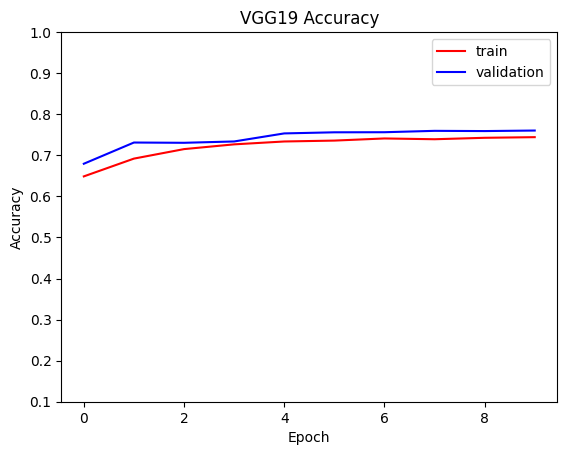

In [215]:
plt.plot(history_rnn.history['accuracy'],color='red',label='train')
plt.plot(history_rnn.history['val_accuracy'],color='blue',label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.1,1.0)
plt.title('VGG19 Accuracy')
plt.legend()
plt.show()

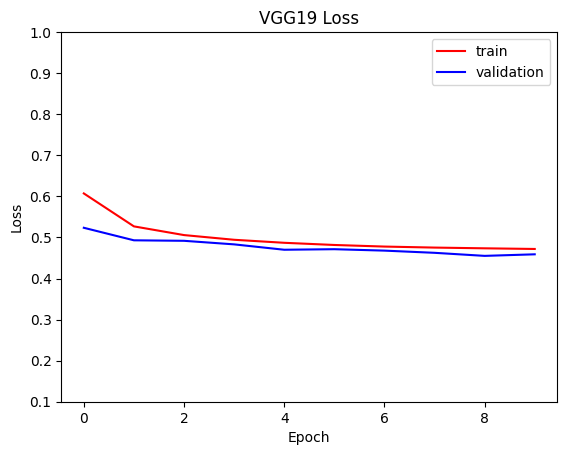

In [216]:
plt.plot(history_rnn.history['loss'],color='red',label='train')
plt.plot(history_rnn.history['val_loss'],color='blue',label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.1,1.0)
plt.title('VGG19 Loss')
plt.legend()
plt.show()

# LSTM

In [217]:
model = Sequential([
    LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])


In [218]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [219]:
history_lstm=model.fit(X_train, y_train, epochs=10,validation_data=(X_test, y_test))

Epoch 1/10
938/938 [==============================] - 16s 13ms/step - loss: 0.5359 - accuracy: 0.6819 - val_loss: 0.5221 - val_accuracy: 0.7064
Epoch 2/10
938/938 [==============================] - 13s 14ms/step - loss: 0.5082 - accuracy: 0.7080 - val_loss: 0.4857 - val_accuracy: 0.7299
Epoch 3/10
938/938 [==============================] - 12s 13ms/step - loss: 0.4964 - accuracy: 0.7197 - val_loss: 0.4811 - val_accuracy: 0.7388
Epoch 4/10
938/938 [==============================] - 13s 14ms/step - loss: 0.4909 - accuracy: 0.7285 - val_loss: 0.4888 - val_accuracy: 0.7240
Epoch 5/10
938/938 [==============================] - 12s 13ms/step - loss: 0.4905 - accuracy: 0.7258 - val_loss: 0.4655 - val_accuracy: 0.7480
Epoch 6/10
938/938 [==============================] - 12s 13ms/step - loss: 0.4820 - accuracy: 0.7345 - val_loss: 0.4694 - val_accuracy: 0.7600
Epoch 7/10
938/938 [==============================] - 12s 13ms/step - loss: 0.4828 - accuracy: 0.7295 - val_loss: 0.4701 - val_accuracy:

In [220]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"LSTM Test Accuracy: {test_acc * 100:.2f}%")

625/625 [==============================] - 3s 5ms/step - loss: 0.4527 - accuracy: 0.7630
LSTM Test Accuracy: 76.30%


Visualization

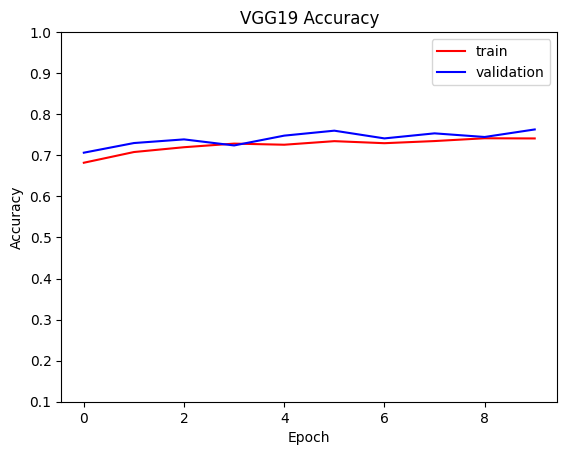

In [221]:
plt.plot(history_lstm.history['accuracy'],color='red',label='train')
plt.plot(history_lstm.history['val_accuracy'],color='blue',label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.1,1.0)
plt.title('VGG19 Accuracy')
plt.legend()
plt.show()

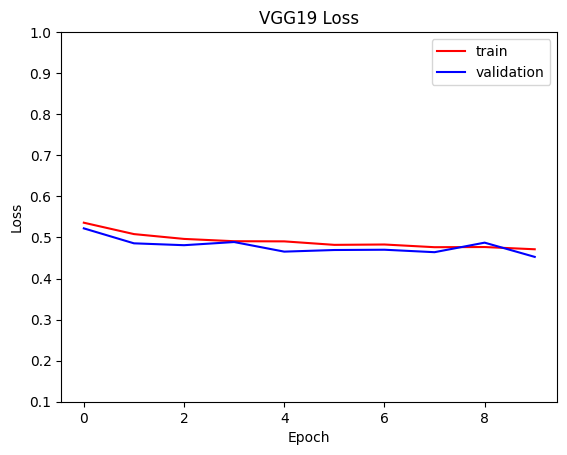

In [222]:
plt.plot(history_lstm.history['loss'],color='red',label='train')
plt.plot(history_lstm.history['val_loss'],color='blue',label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.1,1.0)
plt.title('VGG19 Loss')
plt.legend()
plt.show()

In [223]:
with open('word2vec_model.pkl', 'wb') as file:
    pickle.dump(word2vec_model, file)

In [224]:
with open ('model.pkl','wb') as file:
  pickle.dump(rfc,file)